<a href="https://colab.research.google.com/github/J4rv12/web3-trader-behavior-analysis/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

## Load data

In [28]:
sentiment = pd.read_csv("/content/drive/MyDrive/Data/fear_greed_index.csv")
trades = pd.read_csv("/content/drive/MyDrive/Data/historical_data.csv")

print("Sentiment dataset shape:", sentiment.shape)
print("Trades dataset shape:", trades.shape)

print("Columns:", sentiment.columns.tolist())
print("Columns:", trades.columns.tolist())

Sentiment dataset shape: (2644, 4)
Trades dataset shape: (211224, 16)
Columns: ['timestamp', 'value', 'classification', 'date']
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


## Preprocessing

In [29]:
# Convert timestamp columns
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Align both datasets by date (ignore time, keep only date part)
sentiment['date_only'] = sentiment['date'].dt.date
trades['date_only'] = trades['Timestamp IST'].dt.date

# Merge on date
merged = pd.merge(trades, sentiment[['date_only', 'classification']], on='date_only', how='left')

# Handle missing sentiment labels
total_trades = len(merged)
missing_sentiment = merged['classification'].isna().sum()

print(f"\nTotal trades: {total_trades}")
print(f"Trades without sentiment classification: {missing_sentiment} ({(missing_sentiment/total_trades)*100:.2f}%)")

merged_all = merged.copy()
merged = merged.dropna(subset=['classification'])
print(f"Trades retained for analysis: {len(merged)}")

print("Merged dataset shape:", merged.shape)
print("Sample merged data:\n", merged.head())

print("Value counts:\n", merged['classification'].value_counts())

merged.to_csv("/content/drive/MyDrive/Data/merged_trades_sentiment.csv", index=False)


Total trades: 211224
Trades without sentiment classification: 6 (0.00%)
Trades retained for analysis: 211218
Merged dataset shape: (211218, 18)
Sample merged data:
                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4     

## EDA

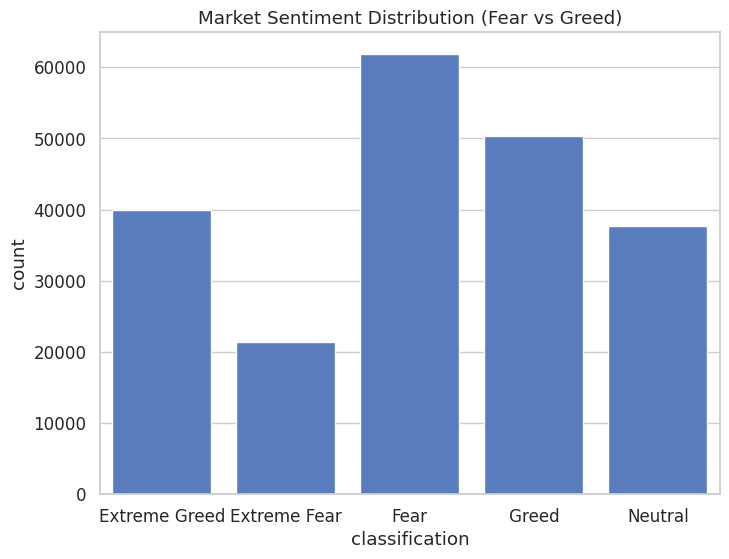

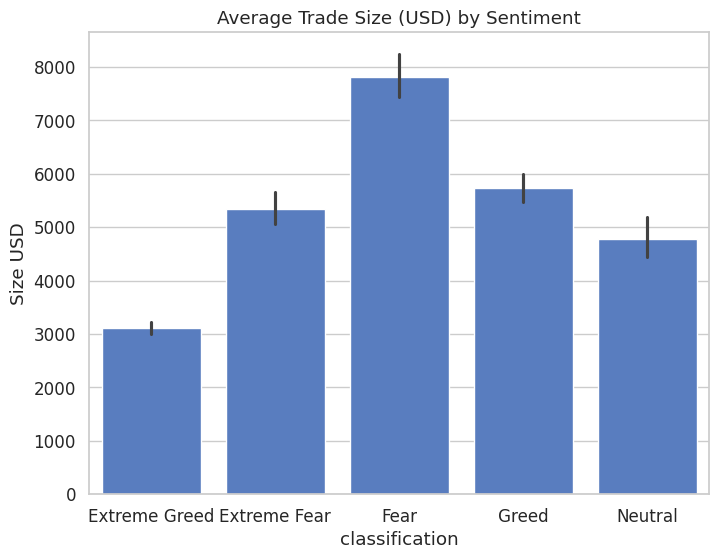

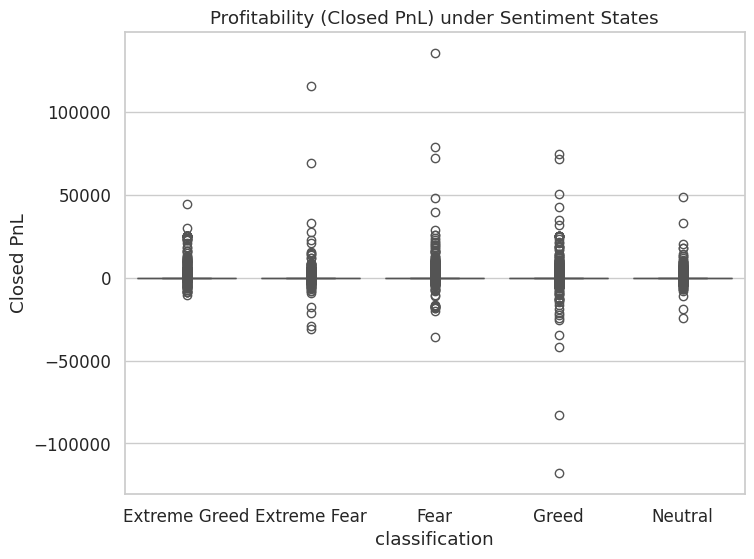

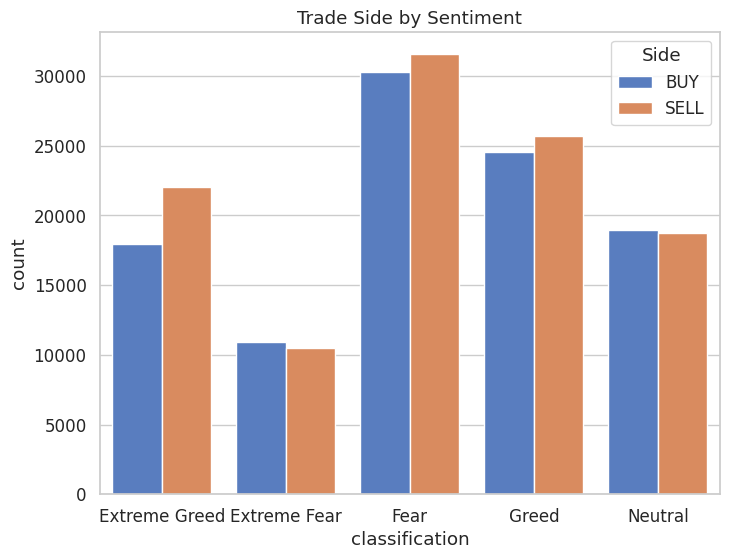

In [30]:
# Sentiment distribution
plt.figure(figsize=(8,6))
sns.countplot(x="classification", data=merged)
plt.title("Market Sentiment Distribution (Fear vs Greed)")
plt.savefig("/content/drive/MyDrive/Screenshot/sentiment_distribution.png")
plt.show()

# Average leverage is NOT directly available
# Instead, analyze trade size and risk (Size USD) by sentiment
plt.figure(figsize=(8,6))
sns.barplot(x="classification", y="Size USD", data=merged, estimator=np.mean)
plt.title("Average Trade Size (USD) by Sentiment")
plt.savefig("/content/drive/MyDrive/Screenshot/trade_size_by_sentiment.png")
plt.show()

# Profitability distribution
plt.figure(figsize=(8,6))
sns.boxplot(x="classification", y="Closed PnL", data=merged)
plt.title("Profitability (Closed PnL) under Sentiment States")
plt.savefig("/content/drive/MyDrive/Screenshot/pnl_distribution.png")
plt.show()

# Side (Long/Short) distribution under sentiment
plt.figure(figsize=(8,6))
sns.countplot(x="classification", hue="Side", data=merged)
plt.title("Trade Side by Sentiment")
plt.savefig("/content/drive/MyDrive/Screenshot/trade_side_by_sentiment.png")
plt.show()

## Risk analysis

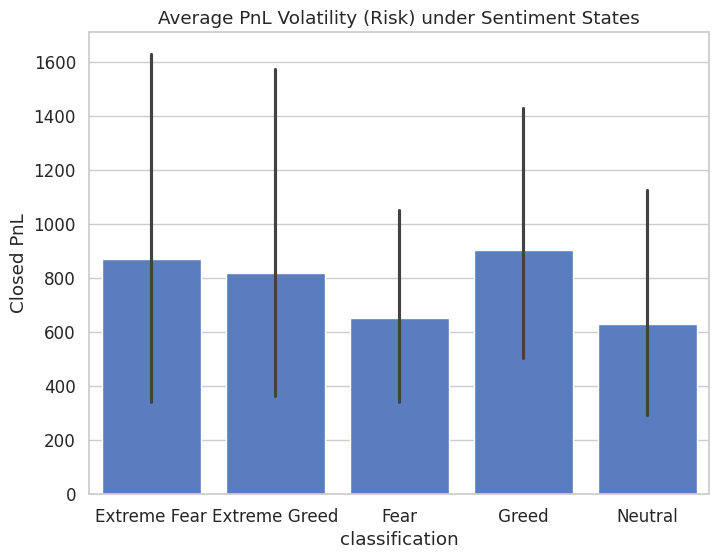

In [31]:
# Risk metric: volatility of PnL per account (std dev)
risk_per_account = merged.groupby(['Account', 'classification'])['Closed PnL'].std().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x="classification", y="Closed PnL", data=risk_per_account)
plt.title("Average PnL Volatility (Risk) under Sentiment States")
plt.savefig("/content/drive/MyDrive/Screenshot/risk_by_sentiment.png")
plt.show()

## Trader profitability segmentation

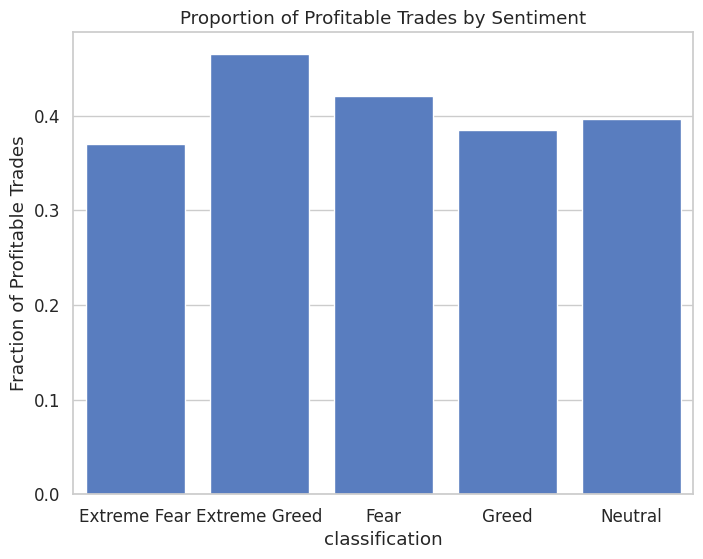

In [32]:
merged['profitable'] = merged['Closed PnL'] > 0
profit_stats = merged.groupby('classification')['profitable'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x="classification", y="profitable", data=profit_stats)
plt.title("Proportion of Profitable Trades by Sentiment")
plt.ylabel("Fraction of Profitable Trades")
plt.savefig("/content/drive/MyDrive/Screenshot/profitability_by_sentiment.png")
plt.show()

## Behavioral shift by sentiment

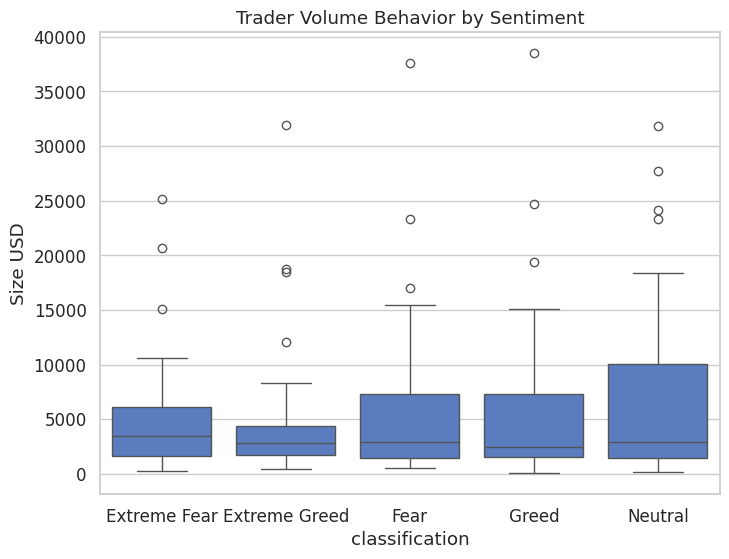

In [33]:
# Average trade size per account under different sentiment
avg_size = merged.groupby(['Account', 'classification'])['Size USD'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.boxplot(x="classification", y="Size USD", data=avg_size)
plt.title("Trader Volume Behavior by Sentiment")
plt.savefig("/content/drive/MyDrive/Screenshot/avg_trade_size_by_sentiment.png")
plt.show()


## Key inferences

### 1. Risk and profitability (success rate)

- Trading during extreme sentiment states introduces the highest risk (large potential PnL swings).
- Traders have the highest trade success rate when the market is at peak exuberance (Extreme Greed).

---

### 2. Profitability distribution

- The median Closed PnL is consistently near zero across all sentiment classifications, suggesting most trades are small gains/losses, or break-even.
- Outliers (extreme positive and negative PnLs) are present in all states, meaning a few trades drive overall aggregate profit/loss, regardless of sentiment.

---

### 3. Trading volume and size

- The highest level of aggregate trading activity occurs during Fear, followed by Greed.
- Larger individual capital deployment occurs during Fear, suggesting institutional or confident traders are active when the market is fearful.

---

### 4. Directional bias (trade side)

- Selling bias in extremes. During periods of Fear, Greed, and Extreme Greed, the count of SELL trades is higher than BUY trades.  
- In Extreme Fear and Neutral states, the BUY and SELL trade counts are nearly equal, suggesting balanced directional conviction during peak panic or calm.

## Strategic implications

The data suggests a strong element of contrarian trading may be effective:

### Exploit Extreme Greed

- The highest success rate occurs in Extreme Greed, which aligns with a selling bias. This indicates that traders who are successfully selling into market euphoria are performing well.

---

### Trade Fear with caution

- While the largest average trade size and highest trade count occur in Fear, this state also carries significantly high PnL volatility (risk).

---

### Risk management

- The extreme PnL volatility in both Extreme Fear and Extreme Greed suggests that trades taken during these periods require the tightest risk management to avoid large losses.

## Summary table

|Aspect|Observation|Implication|
|------|-----------|-----------|
|Profitability|Highest during Extreme Greed|Experienced traders exploit market euphoria|
|PnL Volatility|Max in Extreme Fear & Greed|Requires strong risk management|
|Trade Size|Largest during Fear|Confident traders accumulate positions|
|Trade Direction|Selling bias in extremes|Profit-taking and hedging behavior|
|Median PnL|~0 across all states|Few trades drive most outcomes|